# Import modules

In [1]:
from diced import DicedStore
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

%matplotlib inline

In [2]:
store = DicedStore("gs://flyem-public-connectome")
repo = store.open_repo("medulla7column")
grayscale = repo.get_array("grayscale")
groundtruth = repo.get_array("groundtruth")

# Save and load

In [5]:
import pickle

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def save_object(input_object):
    name = namestr(input_object, globals())[0]
    with open('./save/' + name + '.dmp', 'wb') as f:
        pickle.dump(input_object, f)
        
def load_object(input_object):
    name = namestr(input_object, globals())[0]
    with open('./save/' + name + '.dmp', 'r') as f:
        loaded_f = pickle.load(f)
    return loaded_f

# Get some chunk of array from the index in roi.json

In [6]:
with open('./json_repo/roi.json', 'r') as f:
    data = json.load(f)
    
roi = np.array(data) * 32
roi

array([[1696, 2464, 3232, 4768],
       [1696, 2496, 3232, 4768],
       [1696, 2528, 3232, 4768],
       ..., 
       [7744, 3392, 2080, 3648],
       [7744, 3424, 2080, 3648],
       [7744, 3456, 2080, 3648]])

In [7]:
# Get voxel coordinates from the roi which is densely proofread segmentation
z_start = roi[0, 0]
z_end = z_start + 32
y_start = roi[0, 1]
y_end = y_start + 32
x_start_from = roi[0, 2]
x_end_from = x_start_from
x_start_to = roi[0, 3]
x_end_to = x_start_to

In [8]:
z_start, z_end, y_start, y_end, x_start_from,x_end_from

(1696, 1728, 2464, 2496, 3232, 3232)

In [9]:
chunk_gry = grayscale[z_start:z_end, y_start:y_end, x_start_from:x_end_to]
chunk_gt = groundtruth[z_start:z_end, y_start:y_end, x_start_from:x_end_to]

In [10]:
chunk_gry.shape

(32, 32, 1536)

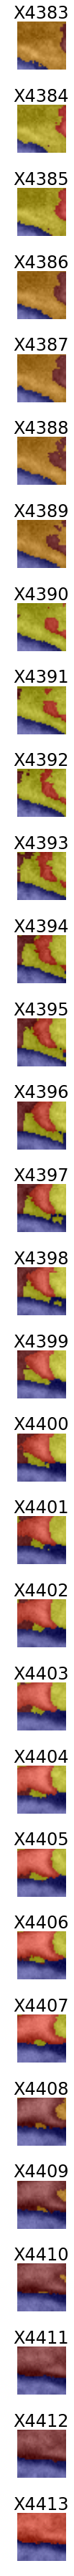

In [21]:
# Plotting several images from the array
plt.figure(figsize=(50, 50))

pic_num = 31   # <-- change the value like 1 ~ 31 
if pic_num < 4:
    pic_num_even = pic_num
    pic_num_odd = 1
else:
    pic_num_even = pic_num // 2
    pic_num_odd = pic_num // 2 + (pic_num % 2)

for i in range(pic_num):
#     plt.subplot(pic_num_even, pic_num_odd, i+1)
    plt.subplot(pic_num_even + pic_num_odd, 1, i+1)
    plt.imshow(chunk_gry[:, :, i * 1], cmap='gray')
    plt.imshow(chunk_gt[:, :, i * 1], alpha=0.5)
    plt.axis('off')
    plt.title('X{}'.format(syn_x+ i), fontsize=24)
    
plt.tight_layout()
plt.show()

# Where is synapse?

In [12]:
with open('./json_repo/synapse.json', 'r') as fsyn:
    synapse = json.load(fsyn)

In [13]:
# check T-bar's location 
print("-----------3 units of T-bar location-----------")
for idx in range(3):
    print(dict(synapse['data'][idx])['T-bar']['location'])
print("------------------------------------ -----------")


# make dictionary like {(body id_1, location_1), (body id_1, location_1)..}
synapse_with_body_id = []
syn_len = len(synapse['data'])

if os.path.exists("./save/synapse_with_body_id.dmp"):
    synapse_with_body_id = load_object(synapse_with_body_id)
    print("complete loading synapse_with_body_id")
else:
    for idx in range(syn_len):
        tmp_tuple = (dict(synapse['data'][idx])['T-bar']['body ID'], 
                     dict(synapse['data'][idx])['T-bar']['location'])
        synapse_with_body_id.append(tmp_tuple)
    synapse_with_body_id = dict(synapse_with_body_id)
    save_object(synapse_with_body_id)
    print("complete saving synapse_with_body_id")

-----------3 units of T-bar location-----------
[1858, 2225, 6584]
[1859, 2181, 6696]
[1860, 2525, 6152]
------------------------------------ -----------
complete loading synapse_with_body_id


# Get synapse_list by body_id

In [15]:
body_id_list = synapse_with_body_id.keys()
idx = 0  # <-- change the idx value like 0,1,2,3...
print("body_id_list[{}]".format(idx))

syn_x = synapse_with_body_id[body_id_list[idx]][0]
syn_y = synapse_with_body_id[body_id_list[idx]][1]
syn_z = synapse_with_body_id[body_id_list[idx]][2]
print("syn_x: %d, syn_y: %d, syn_z: %d"%(syn_x, syn_y, syn_x))

body_id_list[0]
syn_x: 4383, syn_y: 1739, syn_z: 4383


In [16]:
syn_gry = grayscale[syn_z:syn_z+32, syn_y:syn_y+32, syn_x:syn_x+32]
syn_gt = groundtruth[syn_z:syn_z+32, syn_y:syn_y+32, syn_x:syn_x+32]

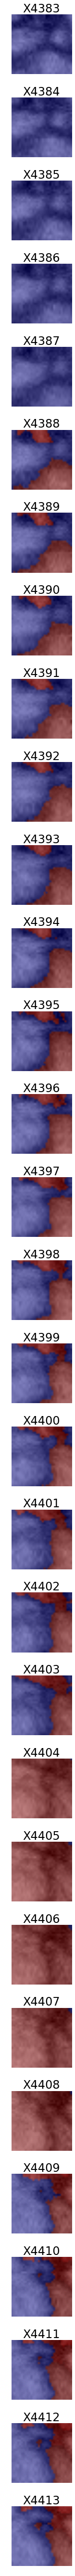

In [21]:
# Plotting several images from the array
plt.figure(figsize=(75, 75))

pic_num = 31  # <-- change the value like 1 ~ 31
if pic_num < 4:
    pic_num_even = pic_num
    pic_num_odd = 1
else:
    pic_num_even = pic_num // 2
    pic_num_odd = pic_num // 2 + (pic_num % 2)

for i in range(pic_num):
#     plt.subplot(pic_num_even, pic_num_odd, i+1)
    plt.subplot(pic_num_even + pic_num_odd, 1, i+1)
    plt.imshow(syn_gry[:, :, i], cmap='gray')
    plt.imshow(syn_gt[:, :, i], alpha=0.5)

    plt.axis('off')
    plt.title('X{}'.format(syn_x+ i * 1), fontsize=24)
    
plt.tight_layout()
plt.show()

# 3D rendering

In [26]:
if os.path.exists("./save/syn_gry.dmp"):
    data = load_object(syn_gry)
    print("complete loading syn_gry")
else:
    save_object(syn_gry)
    data = syn_gry
    print("complete saving syn_gry")

complete loading syn_gry


In [ ]:
from mayavi import mlab
# conda install -c anaconda mayavi 

src = mlab.pipeline.scalar_field(data)
outer = mlab.pipeline.iso_surface(src)

mlab.show()